In [1]:
#! pip install pgmpy

# Bayesian Network Model for Analyses of Road Accidents

## Importing necessary libraries

In [2]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import pathlib
from dataset_preprocessing import preprocessing 

## Load the data

The preprocessing function, imported from dataset_preprocessing.py file, creates our dataset. In particular, it first merges two complex datasets, which contain information about road crashes and users involved, then it filters out irrelevant features and manipulates the others by discretizing and quantizing them. Finally, it saves the processed dataset into the 'data.csv' file.

In [3]:
preprocessing()

We load the dataset from the csv file previously saved by the preprocessing function.

In [4]:
project_cwd = pathlib.Path.cwd()
data = pd.read_csv(f'{project_cwd}/data.csv', sep=',')

Let's have a look on the final dataset.

In [5]:
data.head()

,Age,Speed,RoadUserConditions,PartyType,CrashTime,RoadConditions,Lighting,Weather,Injuries
0,16-20,over speed limits,Not Altered,Car,18-21,Dry,Dark - Street Light,Clear,0
1,41-50,under speed limits,Not Altered,Car,07-12,Dry,Daylight,Cloudy,0
2,51-60,under speed limits,Not Altered,Car,07-12,Dry,Daylight,Cloudy,0
3,21-30,over speed limits,Had Been Drinking,Car,13-17,Dry,Dusk - Dawn,Clear,0
4,51-60,under speed limits,Not Altered,Car,13-17,Dry,Dusk - Dawn,Clear,0


## Bayesian Network construction

We create the Bayesian Network specifying the nodes and their relationship with the others. In particular, the set of nodes represents the features (columns) of our dataset and each edge represents the conditional probability for the nodes it links.

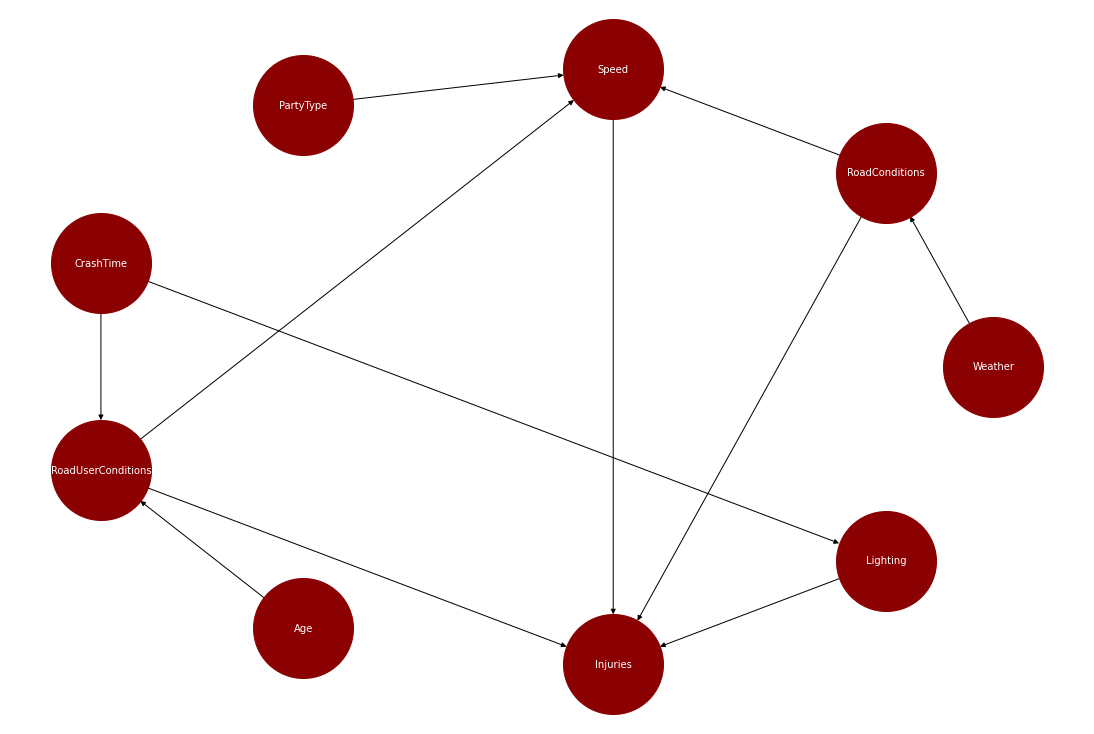

In [6]:
bayesian_model = BayesianNetwork([('Weather', 'RoadConditions'),
                        ('RoadConditions', 'Speed'),
                        ('PartyType', 'Speed'),
                        ('CrashTime', 'RoadUserConditions'),
                        ('Age', 'RoadUserConditions'),
                        ('RoadUserConditions', 'Speed'),
                        ('RoadUserConditions', 'Injuries'),
                        ('Speed', 'Injuries'),
                        ('Lighting', 'Injuries'),
                        ('CrashTime', 'Lighting'),
                        ('RoadConditions', 'Injuries')])

plt.figure(figsize=(15,10))
nx.draw_circular(bayesian_model, with_labels=True, arrowsize=10, node_size=10000, font_size=10,
                 node_color='darkred', font_color = 'white', node_shape='o')
plt.show()

## Conditional Probability Distributions

Firstly, we fit the model on our data in order to estimate the CPDs, using the Maximum Likelihood Estimator. Then, for each node we print out the correspondent CPD table.

In [7]:
bayesian_model.fit(data, estimator=MaximumLikelihoodEstimator)

cpds = bayesian_model.get_cpds()

for cpd in cpds:
    print(cpd, "\n")

+-----------------+-------------+
| Weather(Clear)  | 0.925778    |
+-----------------+-------------+
| Weather(Cloudy) | 0.0413931   |
+-----------------+-------------+
| Weather(Fog)    | 0.000570939 |
+-----------------+-------------+
| Weather(Rain)   | 0.0316871   |
+-----------------+-------------+
| Weather(Wind)   | 0.000570939 |
+-----------------+-------------+ 

+--------------------------+-----------------------+-----+--------------+---------------+---------------+
| Weather                  | Weather(Clear)        | ... | Weather(Fog) | Weather(Rain) | Weather(Wind) |
+--------------------------+-----------------------+-----+--------------+---------------+---------------+
| RoadConditions(Dry)      | 0.9870490286771508    | ... | 1.0          | 0.0           | 1.0           |
+--------------------------+-----------------------+-----+--------------+---------------+---------------+
| RoadConditions(Slippery) | 0.0006167129201356768 | ... | 0.0          | 0.0           | 0.0 

Since the Bayesian Network representation is based on the concept of conditional independency between nodes, we can describe their joint probability distribution with a number of parameter much smaller than the full joint probability distribution.

In [8]:
n_parameters = 0
for cpd in cpds:
    n_parameters += cpd.get_values().shape[0]*cpd.get_values().shape[1]
print("The number of parameters of the Bayesian Network is", n_parameters)

original_parameters = 1
for i in bayesian_model.nodes():
    original_parameters *= len(data[i].unique())
print("The number of parameters of the full joint probability distribution is", original_parameters)

The number of parameters of the Bayesian Network is 705
The number of parameters of the full joint probability distribution is 324000


## Independencies

Following the concept of local semantics, we print the local indipendencies of each variable.

In [9]:
nodes = bayesian_model.nodes()

for node in nodes:
  print("The local independencies of \'{}\' are:".format(node), "\n" ,bayesian_model.local_independencies(node), "\n")

The local independencies of 'Weather' are: 
 (Weather ⟂ Lighting, CrashTime, Age, RoadUserConditions, PartyType) 

The local independencies of 'RoadConditions' are: 
 (RoadConditions ⟂ Lighting, CrashTime, Age, RoadUserConditions, PartyType | Weather) 

The local independencies of 'Speed' are: 
 (Speed ⟂ Lighting, Weather, Age, CrashTime | RoadConditions, PartyType, RoadUserConditions) 

The local independencies of 'PartyType' are: 
 (PartyType ⟂ RoadConditions, Lighting, CrashTime, Age, RoadUserConditions, Weather) 

The local independencies of 'CrashTime' are: 
 (CrashTime ⟂ RoadConditions, Weather, Age, PartyType) 

The local independencies of 'RoadUserConditions' are: 
 (RoadUserConditions ⟂ RoadConditions, Lighting, Weather, PartyType | CrashTime, Age) 

The local independencies of 'Age' are: 
 (Age ⟂ RoadConditions, Lighting, CrashTime, Weather, PartyType) 

The local independencies of 'Injuries' are: 
 (Injuries ⟂ Weather, Age, PartyType, CrashTime | Lighting, Speed, RoadConditi

## Markov Blanket

Given a certain node (marked as red in the network), we print and visualize the correspondent Markov Blanket, represented by the set of node marked as green.

The Markov Blanket of Weather is: ['RoadConditions'].




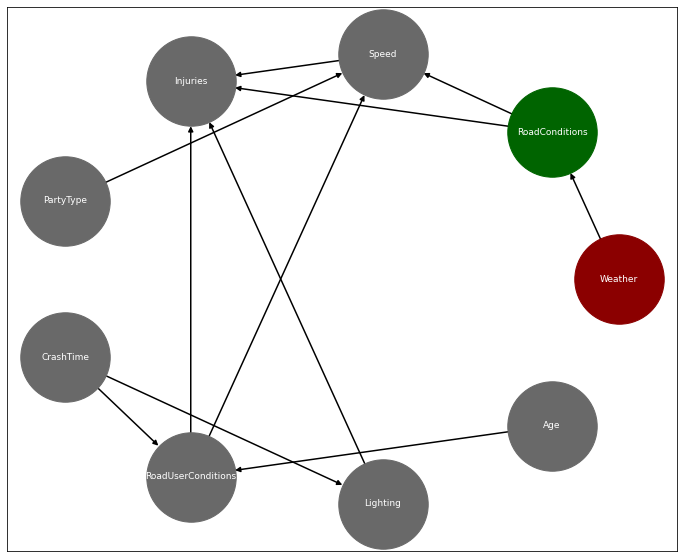

The Markov Blanket of RoadConditions is: ['Injuries', 'Weather', 'PartyType', 'Lighting', 'RoadUserConditions', 'Speed'].




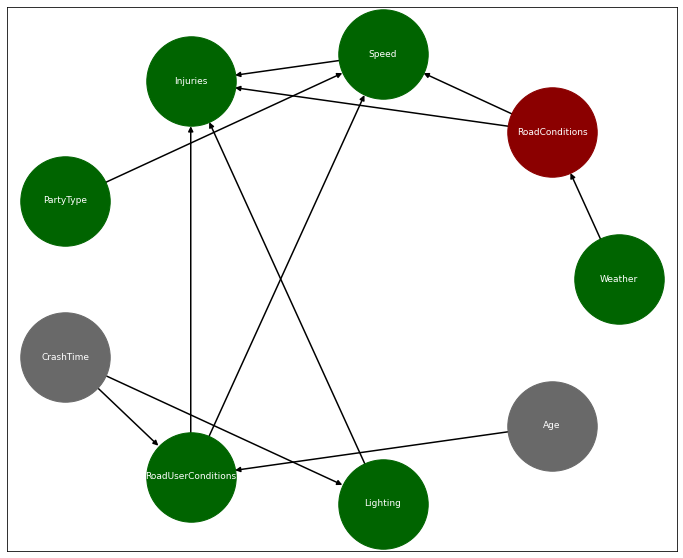

The Markov Blanket of Speed is: ['RoadConditions', 'Injuries', 'PartyType', 'Lighting', 'RoadUserConditions'].




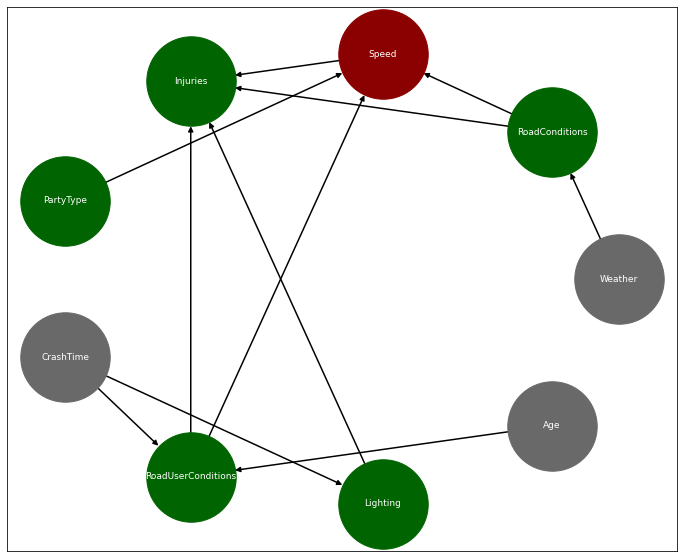

The Markov Blanket of PartyType is: ['RoadConditions', 'Speed', 'RoadUserConditions'].




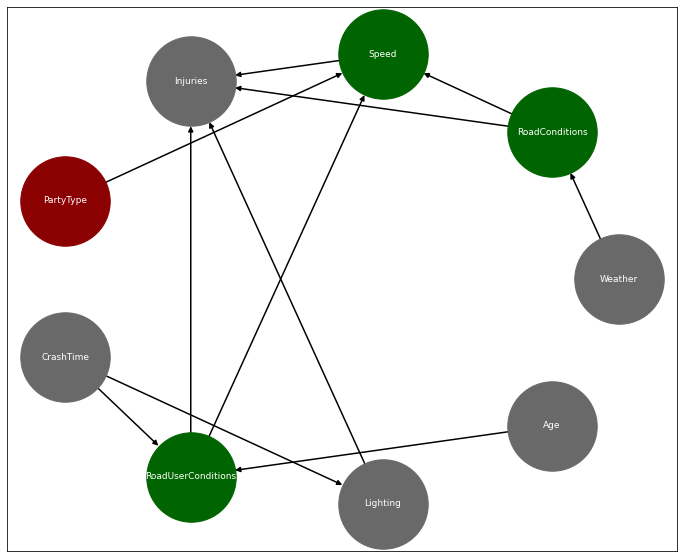

The Markov Blanket of CrashTime is: ['Lighting', 'Age', 'RoadUserConditions'].




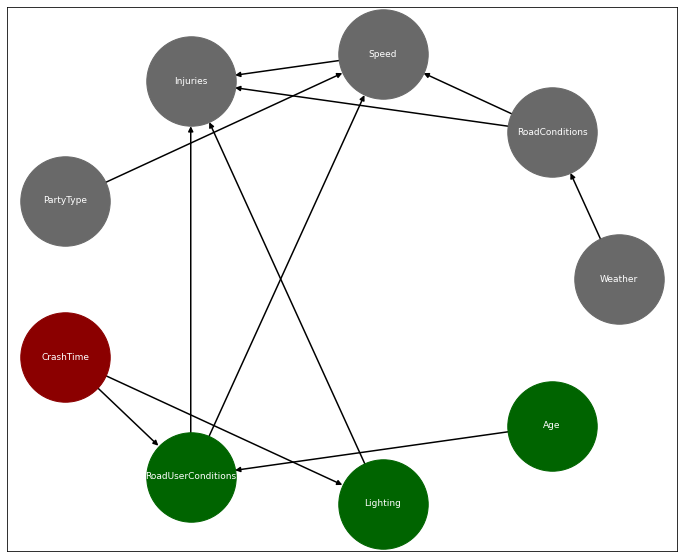

The Markov Blanket of RoadUserConditions is: ['RoadConditions', 'Injuries', 'PartyType', 'Lighting', 'CrashTime', 'Age', 'Speed'].




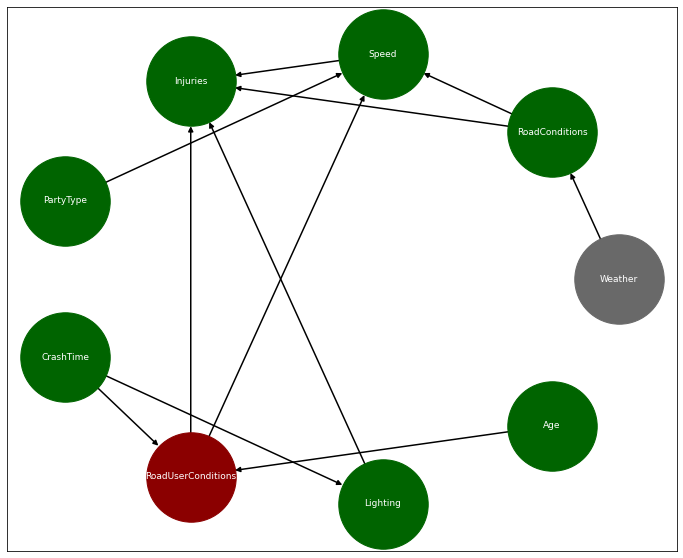

The Markov Blanket of Age is: ['CrashTime', 'RoadUserConditions'].




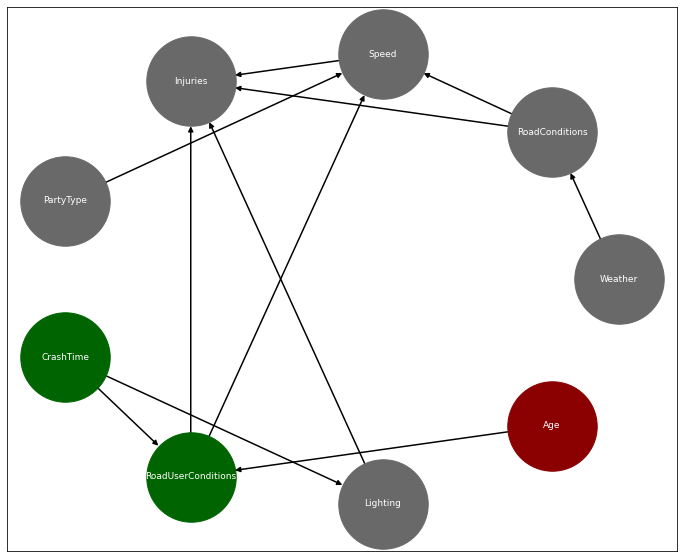

The Markov Blanket of Lighting is: ['RoadConditions', 'Injuries', 'CrashTime', 'RoadUserConditions', 'Speed'].




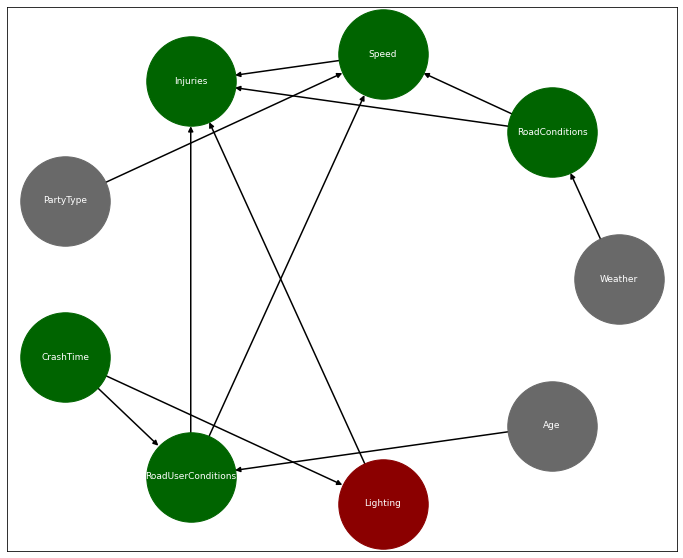

In [10]:
leaves = bayesian_model.get_leaves()
edges = bayesian_model.edges()
nodes = bayesian_model.nodes()

markov_blanket = {}

node_size = 8000

for node in nodes:
    if not node in leaves:
        markov_blanket[node] = bayesian_model.get_markov_blanket(node)
        print('The Markov Blanket of {} is: {}.'.format(node, markov_blanket[node]))
        print('\n')
        
        DAG = nx.DiGraph()
        DAG.add_edges_from(edges)

        fig = plt.figure(figsize = (12,10))
        pos = nx.circular_layout(DAG)
        nx.draw_networkx_edges(DAG, pos, edge_color = 'black', width = 1.5, arrows = True, node_shape='o', node_size=node_size)
        nx.draw_networkx_nodes(bayesian_model, pos, nodelist = [node], node_color = 'darkred', node_shape="o",node_size=node_size)
        nx.draw_networkx_nodes(DAG, pos, nodelist = markov_blanket[node], node_color = 'darkgreen', node_size=node_size)
        nx.draw_networkx_nodes(DAG, pos, nodelist = [n for n in nodes if n not in markov_blanket[node] and n != node], node_color = 'dimgrey', node_size=node_size)
        nx.draw_networkx_labels(DAG, pos, font_size = 9, font_color="white")
        plt.show()

## Active trails

Now we look for active trails between the nodes of the bayesian network. We know that a trail can be activated by the topology of the network or by some evidence, however the evidence can also break some active trails. Indeed if two nodes are connected we can affirm that the infernece between the two nodes flows, so they are not independent, while if they are not connected the two nodes are independent given the corresponding evidence.

### Is there an active trail between *CrashTime* and *RoadConditions*?

In [11]:
bayesian_model.is_dconnected("CrashTime","RoadConditions")

False

Indeed there is no flow of inference between ***CrashTime*** and ***RoadConditions***.

### Is there an active trail between *CrashTime* and *RoadConditions* given *Speed*?

In [12]:
bayesian_model.is_dconnected("CrashTime","RoadConditions", observed="Speed") 

True

Indeed the inference flows between ***CrashTime*** and ***RoadConditions*** thanks to the *V-rule*.

### Is there an active trail between *CrashTime* and *RoadConditions* given *Speed* and *RoadUserConditions*?

In [13]:
bayesian_model.is_dconnected("CrashTime","RoadConditions", observed=["Speed","RoadUserConditions"]) # ruined v-structured

False

Indeed there is no flow of inference between ***CrashTime*** and ***RoadConditions*** due to ***RoadUserConditions***.

### Is there an active trail between *CrashTime* and *Age*?

In [14]:
bayesian_model.is_dconnected("CrashTime","Age")

False

Indeed there is no flow of inference between ***CrashTime*** and ***Age***.

### Is there an active trail between *CrashTime* and *Age* given *RoadUserConditions*?

In [15]:
bayesian_model.is_dconnected("CrashTime","Age",observed="RoadUserConditions") # v-structured

True

Indeed the inference flows between ***CrashTime*** and ***Age*** thanks to the *V-rule*.

### Is there an active trail between *Injuries* and *Weather* given *RoadConditions*?

In [16]:
bayesian_model.is_dconnected("Injuries","Weather",observed="RoadConditions") # ruined flow of inference by evidence

False

Indeed there is no flow of inference between ***Injuries*** and ***Weather*** due to ***RoadConditions***.

### Is there an active trail between *RoadConditions* and *Lighting* given *Injuries*?

In [17]:
bayesian_model.is_dconnected("RoadConditions","Lighting",observed="Injuries") # v-structured

True

Indeed the inference flows between ***RoadConditions*** and ***Lighting*** thanks to the *V-rule*.

### Is there an active trail between *RoadConditions* and *Lighting*?

In [18]:
bayesian_model.is_dconnected("RoadConditions","Lighting")

False

Indeed there is no flow of inference between ***RoadConditions*** and ***Lighting***.

### Is there an active trail between *RoadConditions* and *Lighting* given *Injuries*  and *Speed*?

In [19]:
bayesian_model.is_dconnected("RoadConditions","Lighting",observed=["Injuries","Speed"])

True

Indeed the inference flows between ***RoadConditions*** and ***Lighting*** thanks to the *V-rule*.

### Is there an active trail between *Lighting* and *RoadUserConditions*?

In [20]:
bayesian_model.is_dconnected("Lighting","RoadUserConditions")

True

Indeed the inference flows between ***RoadConditions*** and ***Lighting***.

### Is there an active trail between *Weather* and *Injuries* given *RoadConditions*?

In [21]:
bayesian_model.is_dconnected("Weather","Injuries",observed=["RoadConditions"])

False

Indeed the inference flows between ***Weather*** and ***Injuries*** thanks to the *V-rule*.

## Exact Inference

In order to better analyse our network and the relationship between features, we compute the conditional probability distribution over some variables of interest (*query variables*) with the so called exact inference, using the **variable elimination** method.

In [22]:
exact_inference_ve = VariableElimination(bayesian_model)

For each query variable we want to infer about, we first print out the correspondent absolute probability distribution. 
Then, adding some evidences,  we compare if and how the conditional probability distribution changes with respect to the absolute one.

### Query 1 - *Injuries | RoadUserConditions*

In [23]:
print('The absolute probability distribution of {} is:\n'.format('Injuries'))
print('P(Injuries)')
query = exact_inference_ve.query(["Injuries"], show_progress = False);
print(query,'\n')

print('The conditional probability distributions of {} given {} is:\n'.format('Injuries','RoadUserConditions'))

print('P(Injuries | RoadUserConditions = Not Altered)')
query = exact_inference_ve.query(["Injuries"], evidence = {"RoadUserConditions" : 'Not Altered'}, show_progress=False);
print(query,'\n')

print('P(Injuries | RoadUserConditions = Sleepy/Fatigued)')
query = exact_inference_ve.query(["Injuries"], evidence = {"RoadUserConditions" : 'Sleepy/Fatigued'}, show_progress=False);
print(query,'\n')

print('P(Injuries | RoadUserConditions = Had Been Drinking)')
query = exact_inference_ve.query(["Injuries"], evidence = {"RoadUserConditions" : 'Had Been Drinking'}, show_progress=False);
print(query,'\n')

print('P(Injuries | RoadUserConditions = Under Drug Influence)')
query = exact_inference_ve.query(["Injuries"], evidence = {"RoadUserConditions":"Under Drug Influence"}, show_progress=False);
print(query)

The absolute probability distribution of Injuries is:

P(Injuries)
+-------------+-----------------+
| Injuries    |   phi(Injuries) |
+=============+=================+
| Injuries(0) |          0.6968 |
+-------------+-----------------+
| Injuries(1) |          0.3032 |
+-------------+-----------------+ 

The conditional probability distributions of Injuries given RoadUserConditions is:

P(Injuries | RoadUserConditions = Not Altered)
+-------------+-----------------+
| Injuries    |   phi(Injuries) |
+=============+=================+
| Injuries(0) |          0.6993 |
+-------------+-----------------+
| Injuries(1) |          0.3007 |
+-------------+-----------------+ 

P(Injuries | RoadUserConditions = Sleepy/Fatigued)
+-------------+-----------------+
| Injuries    |   phi(Injuries) |
+=============+=================+
| Injuries(0) |          0.6702 |
+-------------+-----------------+
| Injuries(1) |          0.3298 |
+-------------+-----------------+ 

P(Injuries | RoadUserConditions

The absolute probability of having an accident with injuries is about 30%, but the probability changes when considering user conditions.
In particular, it rises a bit if the user *Had Been Drinking* or if he is *Sleepy/Fatigued*, while it rises significantly when the user is *Under Drug Influence*.

### Query 2 - *Age | RoadUserConditions*

In [24]:
print('The absolute probability distribution of {} is:\n'.format('Age'))
print('P(Age)')
query = exact_inference_ve.query(["Age"], show_progress=False);
print(query,'\n')


print('The conditional probability distributions of {} given {} is:\n'.format('Age','RoadUserConditions'))

print('P(Age | RoadUserConditions = Had Been Drinking)')
query = exact_inference_ve.query(["Age"], evidence = {"RoadUserConditions" : "Had Been Drinking"}, show_progress=False);
print(query,'\n')

print('P(Age | RoadUserConditions = Under Drug Influence)')
query = exact_inference_ve.query(["Age"], evidence = {"RoadUserConditions" : "Under Drug Influence"}, show_progress=False);
print(query,'\n')

The absolute probability distribution of Age is:

P(Age)
+------------+------------+
| Age        |   phi(Age) |
+============+============+
| Age(1-15)  |     0.0117 |
+------------+------------+
| Age(16-20) |     0.0894 |
+------------+------------+
| Age(21-30) |     0.2581 |
+------------+------------+
| Age(31-40) |     0.2007 |
+------------+------------+
| Age(41-50) |     0.1721 |
+------------+------------+
| Age(51-60) |     0.1367 |
+------------+------------+
| Age(61-70) |     0.0856 |
+------------+------------+
| Age(71-80) |     0.0363 |
+------------+------------+
| Age(>80)   |     0.0094 |
+------------+------------+ 

The conditional probability distributions of Age given RoadUserConditions is:

P(Age | RoadUserConditions = Had Been Drinking)
+------------+------------+
| Age        |   phi(Age) |
+============+============+
| Age(1-15)  |     0.0100 |
+------------+------------+
| Age(16-20) |     0.0629 |
+------------+------------+
| Age(21-30) |     0.3021 |
+-

The absolute probability distribution of users' ages underlines that the majority of people having a crash falls into the 21-60 age group. 
When considering the user conditions, the probability distribution changes in different ways:
* given that the user *Had Been Drinking*, the probability of that user to fall into the 21-40 age group increases significantly
* given that the user is *Under Drug Influence*, the probability of that user to fall into the 21-30 age group decreases, while the probability of falling into the 31-60 increases significantly

### Query 3 - *CrashTime | Age & RoadUserConditions*

In [25]:
print('The absolute probability distribution of {} is:\n'.format('CrashTime'))
print('P(CrashTime)')
query = exact_inference_ve.query(["CrashTime"], show_progress=False);
print(query,'\n')

print('The conditional probability distribution of {} given {} is:\n'.format('CrashTime','Age'))
print('P(CrashTime | Age = 21-30)')
query = exact_inference_ve.query(["CrashTime"], evidence = {"Age" : "21-30"}, show_progress=False);
print(query,'\n')

print('The conditional probability distribution of {} given {} is:\n'.format('CrashTime','RoadUserConditions'))
print('P(CrashTime | RoadUserConditions = Had Been Drinking)')
query = exact_inference_ve.query(["CrashTime"], evidence = {"RoadUserConditions":"Had Been Drinking"}, show_progress=False);
print(query,'\n')

print('The conditional probability distribution of {} given {} and {} is:\n'.format('CrashTime','Age','RoadUserConditions'))
print('P(CrashTime | Age = 21-30, RoadUserConditions = Had Been Drinking)')
query = exact_inference_ve.query(["CrashTime"], evidence = {"Age" : "21-30","RoadUserConditions":"Had Been Drinking"}, show_progress=False);
print(query,'\n')


The absolute probability distribution of CrashTime is:

P(CrashTime)
+------------------+------------------+
| CrashTime        |   phi(CrashTime) |
+==================+==================+
| CrashTime(01-06) |           0.0771 |
+------------------+------------------+
| CrashTime(07-12) |           0.2572 |
+------------------+------------------+
| CrashTime(13-17) |           0.3257 |
+------------------+------------------+
| CrashTime(18-21) |           0.2449 |
+------------------+------------------+
| CrashTime(22-24) |           0.0951 |
+------------------+------------------+ 

The conditional probability distribution of CrashTime given Age is:

P(CrashTime | Age = 21-30)
+------------------+------------------+
| CrashTime        |   phi(CrashTime) |
+==================+==================+
| CrashTime(01-06) |           0.0771 |
+------------------+------------------+
| CrashTime(07-12) |           0.2572 |
+------------------+------------------+
| CrashTime(13-17) |           0.

The absolute probability distribution of crashes time underlines that the majority of the accidents happens between 7 a.m. and 9 p.m..

Then, adding the user age as a piece of evidence, the probability distribution doesn't change since ***Age*** and ***CrashTime*** are independent. 

Instead, using the user conditions as a piece of evidence, we can notice that when the user *Had Been Drinking*, the probability distribution of ***CrashTime*** changes significantly, seeing increased the probability that the accident happened during the night.

Finally, when considering both user age and conditions as evidences, the probability distribution of ***CrashTime*** changes again but in a different manner with respect to the case where only ***RoadUserConditions*** was used as evidence. That's because, given ***RoadUserConditions***, ***Age*** and ***CrashTime*** are no longer independent and the inference flows between them.

### Query 4 - *Speed | RoadUserConditions*

In [26]:
print('The absolute probability distribution of {} is:\n'.format('Speed'))
print('P(Speed)')
query = exact_inference_ve.query(["Speed"], show_progress=False);
print(query,'\n')

print('The conditional probability distributions of {} given {} is:\n'.format('Speed','RoadUserConditions'))

print('P(Speed | RoadUserConditions = Under Drug Influence)')
query = exact_inference_ve.query(["Speed"], evidence = {"RoadUserConditions":"Under Drug Influence"}, show_progress=False);
print(query,'\n')

print('P(Speed | RoadUserConditions = Had Been Drinking)')
query = exact_inference_ve.query(["Speed"], evidence = {"RoadUserConditions":"Had Been Drinking"}, show_progress=False);
print(query,'\n')

print('P(Speed | RoadUserConditions = Not Altered)')
query = exact_inference_ve.query(["Speed"], evidence = {"RoadUserConditions":"Not Altered"}, show_progress=False);
print(query,'\n')

The absolute probability distribution of Speed is:

P(Speed)
+---------------------------+--------------+
| Speed                     |   phi(Speed) |
+===========================+==============+
| Speed(over speed limits)  |       0.1368 |
+---------------------------+--------------+
| Speed(under speed limits) |       0.8632 |
+---------------------------+--------------+ 

The conditional probability distributions of Speed given RoadUserConditions is:

P(Speed | RoadUserConditions = Under Drug Influence)
+---------------------------+--------------+
| Speed                     |   phi(Speed) |
+===========================+==============+
| Speed(over speed limits)  |       0.3381 |
+---------------------------+--------------+
| Speed(under speed limits) |       0.6619 |
+---------------------------+--------------+ 

P(Speed | RoadUserConditions = Had Been Drinking)
+---------------------------+--------------+
| Speed                     |   phi(Speed) |
+===========================+==

The absolute probability distribution of the user's speed underlines that the majority of people is observing speed limits when having an accident.
When considering the user conditions as piece of evidence, the probability distribution changes in different ways:
* given that the user *Had Been Drinking* or that he's *Under Drug Influence* , the conditional probability of that user to have an accident not observing speed limits increases significantly with respect to the absolute one
* given that the user conditions are *Not Altered*, the conditional probability of that user to have an accident observing speed limits increases a bit with respect to the absolute one

### Query 5 - *RoadUserConditions | CrashTime*

In [27]:
print('The absolute probability distribution of {} is:\n'.format('RoadUserConditions'))
print('P(RoadUserConditions)')
query = exact_inference_ve.query(["RoadUserConditions"], show_progress=False);
print(query,'\n')

print('The conditional probability distributions of {} given {} is:\n'.format('RoadUserConditions','CrashTime'))

print('P(RoadUserConditions | CrashTime = 22-24)')
query = exact_inference_ve.query(["RoadUserConditions"], evidence = {"CrashTime":"22-24"}, show_progress=False);
print(query,'\n')

print('P(RoadUserConditions | CrashTime = 13-17)')
query = exact_inference_ve.query(["RoadUserConditions"], evidence = {"CrashTime":"13-17"}, show_progress=False);
print(query,'\n')

The absolute probability distribution of RoadUserConditions is:

P(RoadUserConditions)
+------------------------------------------+---------------------------+
| RoadUserConditions                       |   phi(RoadUserConditions) |
+==========================================+===========================+
| RoadUserConditions(Had Been Drinking)    |                    0.1284 |
+------------------------------------------+---------------------------+
| RoadUserConditions(Impairment Physical)  |                    0.0021 |
+------------------------------------------+---------------------------+
| RoadUserConditions(Not Altered)          |                    0.8528 |
+------------------------------------------+---------------------------+
| RoadUserConditions(Sleepy/Fatigued)      |                    0.0105 |
+------------------------------------------+---------------------------+
| RoadUserConditions(Under Drug Influence) |                    0.0062 |
+------------------------------------

The absolute probability distribution of the user conditions underlines that the majority of people is in *Not Altered* state when having an accident.
When considering the crash time as piece of evidence, the probability distribution changes in different ways:
* given that the accident happened between 1 p.m. and 5 p.m., the conditional probability of the user to be in *Not Altered* conditions increases with respect to the absolute one
* given that the accident happened between 10 p.m. and 12 a.m., the conditional probability of the user to be in *Not Altered* conditions decreases, while its conditional probability of *Had Been Drinking* increases, with respect to the absolute one.

### Query 6 - *Injuries | Lighting*

In [31]:
print('The absolute probability distribution of {} is:\n'.format('Injuries'))
print('P(Injuries)')
query = exact_inference_ve.query(["Injuries"], show_progress=False);
print(query,'\n')

print('The conditional probability distribution of {} given {} is:\n'.format('Injuries','Lighting'))

print('P(Injuries | Lighting = Dark - No Street Light)')
query = exact_inference_ve.query(["Injuries"], evidence = {"Lighting" : 'Dark - No Street Light'}, show_progress=False);
print(query,'\n')

The absolute probability distribution of Injuries is:

P(Injuries)
+-------------+-----------------+
| Injuries    |   phi(Injuries) |
+=============+=================+
| Injuries(0) |          0.6968 |
+-------------+-----------------+
| Injuries(1) |          0.3032 |
+-------------+-----------------+ 

The conditional probability distribution of Injuries given Lighting is:

P(Injuries | Lighting = Dark - No Street Light)
+-------------+-----------------+
| Injuries    |   phi(Injuries) |
+=============+=================+
| Injuries(0) |          0.5907 |
+-------------+-----------------+
| Injuries(1) |          0.4093 |
+-------------+-----------------+ 



The absolute probability of having a crash with injuries is about 30%, but the probability changes when considering lighting conditions.
In particular, it rises significantly if the lighting conditions are *Dark - No Street Light*.

### Query 7 - *Injuries | RoadConditions & Weather*

In [29]:
print('The conditional probability distribution of {} given {} is:\n'.format('Injuries','RoadConditions'))
print('P(Injuries | RoadConditions = Slippery )')
query = exact_inference_ve.query(["Injuries"], evidence = {"RoadConditions" : 'Slippery'}, show_progress=False);
print(query,'\n')

print('The conditional probability distribution of {} given {} and {} is:\n'.format('Injuries','RoadConditions','Weather'))
print('P(Injuries | RoadConditions = Slippery, Weather = Rain)')
query = exact_inference_ve.query(["Injuries"], evidence = {"RoadConditions" : 'Slippery',"Weather":"Rain"}, show_progress=False);
print(query,'\n')

The conditional probability distribution of Injuries given RoadConditions is:

P(Injuries | RoadConditions = Slippery )
+-------------+-----------------+
| Injuries    |   phi(Injuries) |
+=============+=================+
| Injuries(0) |          0.7036 |
+-------------+-----------------+
| Injuries(1) |          0.2964 |
+-------------+-----------------+ 

The conditional probability distribution of Injuries given RoadConditions and Weather is:

P(Injuries | RoadConditions = Slippery, Weather = Rain)
+-------------+-----------------+
| Injuries    |   phi(Injuries) |
+=============+=================+
| Injuries(0) |          0.7036 |
+-------------+-----------------+
| Injuries(1) |          0.2964 |
+-------------+-----------------+ 



Considering the feature about road accident injuries, we can notice that its conditional probability distribution given ***RoadConditions*** and its conditional probability distribution given ***RoadConditions*** and ***Weather*** are exactly the same. 
That's because ***Injuries*** and ***Weather*** are conditionally independent given ***RoadConditions***.

### Query 8 - *Speed | Weather & Injuries*

In [30]:
print('The absolute probability distribution of {} is:\n'.format('Speed'))
print('P(Speed)')
query = exact_inference_ve.query(["Speed"], show_progress=False);
print(query,'\n')

print('The conditional probability distribution of {} given {} is:\n'.format('Speed','Weather'))
print('P(Speed | Weather = Rain)')
query = exact_inference_ve.query(["Speed"], evidence = {"Weather":"Rain"}, show_progress=False);
print(query,'\n')

print('The conditional probability distribution of {} given {} is:\n'.format('Speed','Injuries'))
print('P(Speed | Injuries = 1)')
query = exact_inference_ve.query(["Speed"], evidence = {"Injuries":1}, show_progress=False);
print(query,'\n')

print('The conditional probability distributions of {} given {} and {} is:\n'.format('Speed','Injuries','Weather'))

print('P(Speed | Injuries = 1, Weather = Rain)')
query = exact_inference_ve.query(["Speed"], evidence = {"Injuries":1,"Weather":"Rain"}, show_progress=False);
print(query,'\n')

print('P(Speed | Injuries = 1, Weather = Clear)')
query = exact_inference_ve.query(["Speed"], evidence = {"Injuries":1,"Weather":"Clear"}, show_progress=False);
print(query,'\n')

The absolute probability distribution of Speed is:

P(Speed)
+---------------------------+--------------+
| Speed                     |   phi(Speed) |
+===========================+==============+
| Speed(over speed limits)  |       0.1368 |
+---------------------------+--------------+
| Speed(under speed limits) |       0.8632 |
+---------------------------+--------------+ 

The conditional probability distribution of Speed given Weather is:

P(Speed | Weather = Rain)
+---------------------------+--------------+
| Speed                     |   phi(Speed) |
+===========================+==============+
| Speed(over speed limits)  |       0.1451 |
+---------------------------+--------------+
| Speed(under speed limits) |       0.8549 |
+---------------------------+--------------+ 

The conditional probability distribution of Speed given Injuries is:

P(Speed | Injuries = 1)
+---------------------------+--------------+
| Speed                     |   phi(Speed) |
+=========================

Considering the feature about the user's speed, we can notice that its conditional probability distribution given weather conditions doesn't change significantly with respect to the absolute one. The same goes for its conditional probability distribution given injuries information as evidence.

Instead, when considering a certain instance of both ***Weather*** and ***Injuries*** as evidences, the conditional probability distribution changes markably. In particular, if the crash caused injuries and the weather was rainy, the probability of the user's speed to be over limits increases with respect to the absolute one.

## Approximate inference

Approximate inference is a method for estimate probabilities in Bayesian networks. The usage of approximate inference is crucial when computing posterior probabilities with exact inference becomes intractable, as for the case of large multiply-connected networks, where the variable elimination method can have exponential time and space complexity. 

There exist different methods to compute the probabilities using approximate inference, but in this study we applied just two of them: the **Rejection sampling** and the **Likelihood weighted sampling**.


In [31]:
inference = BayesianModelSampling(bayesian_model) 

#function to compute the likelihood weighted probability of a varible given specific value 
def prob_LW(samples, variable, value):
    
    weight = 0
    
    #for all the samples we consider only those 
    #that correspond tothe specific value od the variable
    for i in range(0,samples.shape[0]):
        if(samples[variable][i]==value):
            weight += samples['_weight'][i]
    
    return round(weight/np.sum(samples['_weight']),2)

#function to compute the probability using rejection sampling
def prob_RS(samples, variable, value):
    
    tot = 0
    
    #for all the samples we consider only those 
    #that correspond to the specific value od the variable
    for i in range(0,samples.shape[0]):
        if(samples[variable][i]==value):
            tot += 1
    
    return round(tot/samples.shape[0],2)

#function to compute the relative error between the probability 
#computed by the exact inference and the approximated probability
def relative_error(exact_value, approx_value):
    return np.absolute((exact_value - approx_value)/exact_value)

#function to compute the absolute error between the probability 
#computed by the exact inference and the approximated probability
def absolute_error(exact_value, approx_value):
    return np.absolute(exact_value - approx_value)


def run_experiment(sample_size, variable, value, evidences, ref_query):
    
    #Generates weighted sample(s) from joint distribution of the bayesian network,
    #that comply with the given evidence.
    samples_LW = inference.likelihood_weighted_sample(evidence = evidences, 
                                                      size = sample_size)
    
    #Generates sample(s) from joint distribution of the bayesian network, 
    #rejecting those that disagree with the evindence.
    samples_RS = inference.rejection_sample(evidence = evidences, 
                                            size = sample_size)

    # Computing the probabilities of LW samples and RS samples
    query_LW = prob_LW(samples_LW, variable, value)
    query_RS = prob_RS(samples_RS, variable, value)
      
    # Return results
    return np.array([(sample_size, 
                      query_RS, absolute_error(ref_query, query_RS),
                      query_LW, absolute_error(ref_query, query_LW))],
                      dtype = [('sample_size', '<i8'), 
                               ('query_RS', '<f8'),('e_query_RS', '<f8'),
                               ('query_LW', '<f8'),('e_query_LW', '<f8')])

In particular, we focused our analysis on computing the conditional probability of 

*P(Injuries = 1 | RoadUserConditions = Under Drug Influence)*

with both the exact and approximate inference, in order to compare their relative outcomes.

In [32]:
#Reference query for comparison

ref_query = exact_inference_ve.query(["Injuries"], evidence = {"RoadUserConditions" : 'Under Drug Influence'}, show_progress=False).values[1]
print('P(Injuries = 1 | RoadUserConditions = Under Drug Influence) =', ref_query)


P(Injuries = 1 | RoadUserConditions = Under Drug Influence) = 0.3795950064306464


In [33]:
# Likelihood and RS

evidences = [State('RoadUserConditions', 'Under Drug Influence')]
sample_size = 10

results = np.array([],dtype=[('sample_size', '<i8'), 
                             ('query_RS', '<f8'),('e_query_RS', '<f8'),
                             ('query_LW', '<f8'),('e_query_LW', '<f8')])

starting_size_ = 1 # from 10 sample points
final_size = 5     # to 10^5 sample points
experiments = 20   # 20 experiments

for size in np.logspace(starting_size_, final_size, num=experiments, dtype='<i8'):
    results = np.append(results,run_experiment(size,'Injuries', 1, evidences, ref_query))
    
print(results)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1274 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/2069 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3359 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5455 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8858 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/14384 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/23357 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/37926 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/61584 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

[(    10, 0.4 , 0.02040499, 0.16, 0.21959501)
 (    16, 0.19, 0.18959501, 0.17, 0.20959501)
 (    26, 0.42, 0.04040499, 0.34, 0.03959501)
 (    42, 0.38, 0.00040499, 0.64, 0.26040499)
 (    69, 0.39, 0.01040499, 0.38, 0.00040499)
 (   112, 0.33, 0.04959501, 0.29, 0.08959501)
 (   183, 0.37, 0.00959501, 0.37, 0.00959501)
 (   297, 0.36, 0.01959501, 0.42, 0.04040499)
 (   483, 0.4 , 0.02040499, 0.31, 0.06959501)
 (   784, 0.36, 0.01959501, 0.37, 0.00959501)
 (  1274, 0.38, 0.00040499, 0.37, 0.00959501)
 (  2069, 0.4 , 0.02040499, 0.39, 0.01040499)
 (  3359, 0.37, 0.00959501, 0.37, 0.00959501)
 (  5455, 0.38, 0.00040499, 0.35, 0.02959501)
 (  8858, 0.38, 0.00040499, 0.37, 0.00959501)
 ( 14384, 0.38, 0.00040499, 0.38, 0.00040499)
 ( 23357, 0.38, 0.00040499, 0.39, 0.01040499)
 ( 37926, 0.38, 0.00040499, 0.37, 0.00959501)
 ( 61584, 0.38, 0.00040499, 0.38, 0.00040499)
 (100000, 0.38, 0.00040499, 0.38, 0.00040499)]


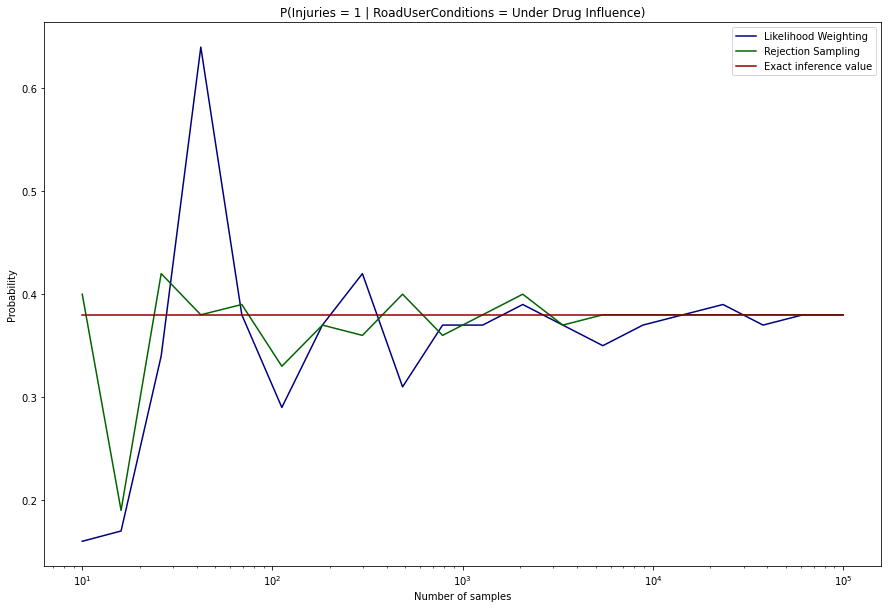

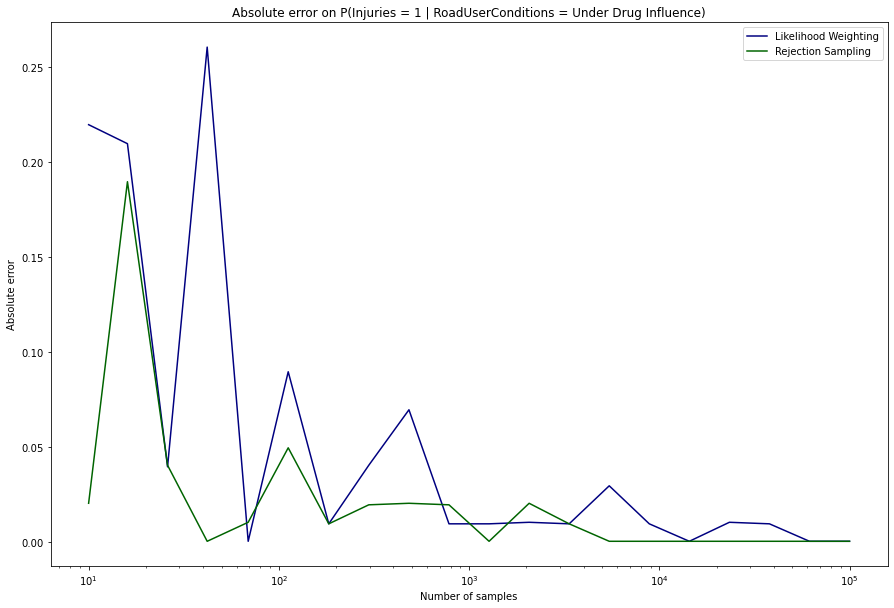

In [34]:
plt.figure(figsize = (15, 10))
# Plot 1

plt.xlabel("Number of samples")
plt.ylabel("Probability")
plt.title('P(Injuries = 1 | RoadUserConditions = Under Drug Influence)')
LWCplot, = plt.semilogx(results['sample_size'],
                        results['query_LW'],
                        'navy',
                        label = "Likelihood Weighting")

RSCplot, = plt.semilogx(results['sample_size'],
                        results['query_RS'],
                        'darkgreen',
                        label = "Rejection Sampling")

VECplot, = plt.semilogx(results['sample_size'],
                        ref_query*np.ones(results.size),
                        'darkred',
                        label = "Exact inference value")

plt.legend(handles = [LWCplot, RSCplot, VECplot])

plt.show()


# Plot 2
plt.figure(figsize = (15, 10))

plt.xlabel("Number of samples")
plt.ylabel("Absolute error")
plt.title('Absolute error on P(Injuries = 1 | RoadUserConditions = Under Drug Influence)')
ELWCplot, = plt.semilogx(results['sample_size'],
                         results['e_query_LW'],
                         'navy',
                         label = "Likelihood Weighting")

ERSCplot, = plt.semilogx(results['sample_size'],
                         results['e_query_RS'],
                         'darkgreen',
                         label = "Rejection Sampling")

plt.legend(handles = [ELWCplot, ERSCplot])

plt.show()

The first plot below shows a comparison between:
* The Likelihood Weighted probability
* The Rejection Sampling probability 
* The Exact inference probability

We can see how increasing the number of sample the approximated probabilities converge to the exact value.

The second plot below shows the comparison between the absolute errors of the two apporximated probabilities with respect to the probability computed by the exact inference.